# Focus on Real/Fake image to classification.
## Use hand-writing HDDM modul (../models/hddm_model.py)

In [17]:
# Required Libraries
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import sys

# confirm the model path
models_path = os.path.abspath("../models")  # 根據相對位置調整路徑
if models_path not in sys.path:
    sys.path.append(models_path)

# 引入 HDDM 模型
from hddm_model import HDDM

In [18]:
from torch.utils.data import random_split, DataLoader
# 定義自定義 Dataset
class ROIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        初始化 ROI Dataset
        :param root_dir: 根資料夾，包括 real 和 fake
        :param transform: 圖像的 transform
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        # 加載資料
        for label, subdir in enumerate(["real", "fake"]):
            subdir_path = os.path.join(root_dir, subdir)
            for file_name in os.listdir(subdir_path):
                if file_name.endswith((".jpg", ".jpeg", ".png")):
                    self.data.append(os.path.join(subdir_path, file_name))
                    self.labels.append(label)  # real: 0, fake: 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

# 資料準備
data_root = "../HDDM_Project/data/ROI_data"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# 初始化數據集
dataset = ROIDataset(root_dir=data_root, transform=transform)

# 訓練集和測試集的分割比例
train_ratio = 0.8
test_ratio = 1 - train_ratio

# 計算訓練集與測試集的大小
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# 使用 random_split 分割數據集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 創建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Total dataset size: {len(dataset)}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Total dataset size: 25898
Training dataset size: 20718
Testing dataset size: 5180


In [19]:
# !pip3 install torch torchvision torchaudio

In [20]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

print(device)

mps


In [21]:
# 初始化 HDDM 模型
model = HDDM().to(device)

In [22]:
# 損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
import matplotlib.pyplot as plt

# 訓練與評估函數
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    model.train()
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        # 訓練模式
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # 計算訓練準確率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 計算平均損失和準確率
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # 評估模式
        model.eval()
        test_loss, test_acc = evaluate(model, test_loader, criterion)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

        # 打印每個 epoch 的結果
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"  Training   - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"  Evaluation - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

    return train_loss_history, train_acc_history, test_loss_history, test_acc_history


# 評估函數
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # 計算準確率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


In [24]:
# 繪製訓練與測試損失與準確率曲線
def plot_training_and_evaluation(train_loss, train_acc, test_loss, test_acc):
    epochs = range(1, len(train_loss) + 1)

    # 繪製損失曲線
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, test_loss, label='Testing Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # 繪製準確率曲線
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, test_acc, label='Testing Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch [1/10]
  Training   - Loss: 0.6088, Accuracy: 0.6664
  Evaluation - Loss: 0.5746, Accuracy: 0.6828
Epoch [2/10]
  Training   - Loss: 0.5804, Accuracy: 0.6817
  Evaluation - Loss: 0.5685, Accuracy: 0.6911
Epoch [3/10]
  Training   - Loss: 0.5714, Accuracy: 0.6874
  Evaluation - Loss: 0.5615, Accuracy: 0.6838
Epoch [4/10]
  Training   - Loss: 0.5611, Accuracy: 0.6956
  Evaluation - Loss: 0.5613, Accuracy: 0.6931
Epoch [5/10]
  Training   - Loss: 0.5536, Accuracy: 0.6994
  Evaluation - Loss: 0.5702, Accuracy: 0.6861
Epoch [6/10]
  Training   - Loss: 0.5452, Accuracy: 0.7065
  Evaluation - Loss: 0.5543, Accuracy: 0.6932
Epoch [7/10]
  Training   - Loss: 0.5369, Accuracy: 0.7118
  Evaluation - Loss: 0.5583, Accuracy: 0.6988
Epoch [8/10]
  Training   - Loss: 0.5265, Accuracy: 0.7176
  Evaluation - Loss: 0.5558, Accuracy: 0.6950
Epoch [9/10]
  Training   - Loss: 0.5142, Accuracy: 0.7262
  Evaluation - Loss: 0.5624, Accuracy: 0.6965
Epoch [10/10]
  Training   - Loss: 0.4968, Accuracy: 0.

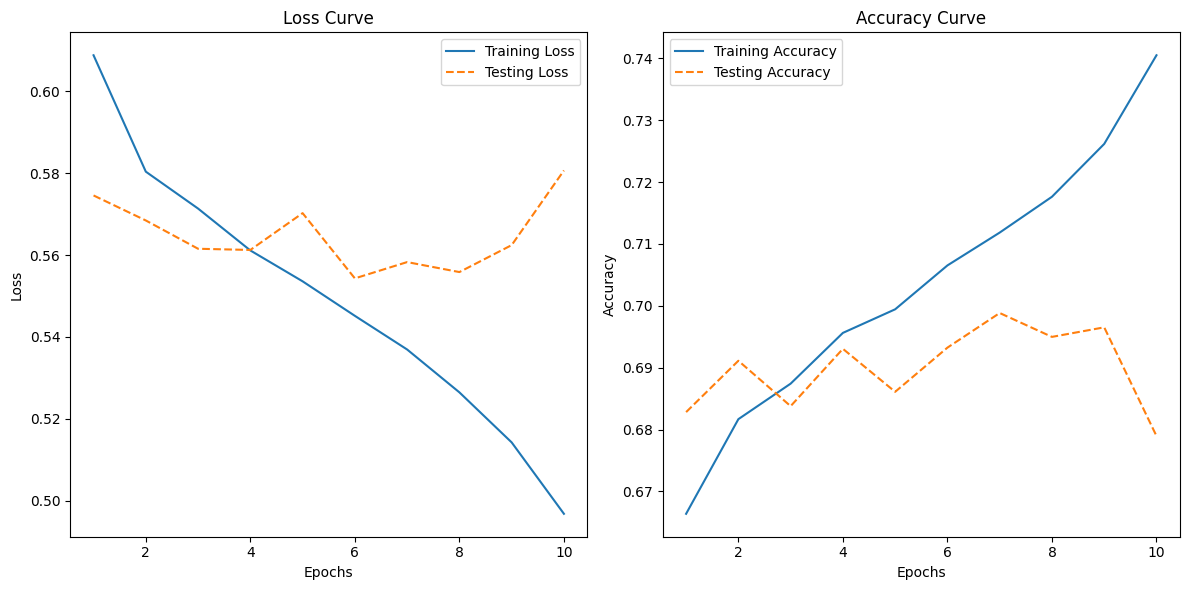

Model saved to ../models/hddm_model.pth


In [25]:
# 執行訓練與評估
train_loss, train_acc, test_loss, test_acc = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, epochs=10
)

# 繪製結果
plot_training_and_evaluation(train_loss, train_acc, test_loss, test_acc)

# 保存模型
model_save_path = "../models/hddm_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

In [28]:
# !pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 11.4 MB/s eta 0:00:00a 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 22.0 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


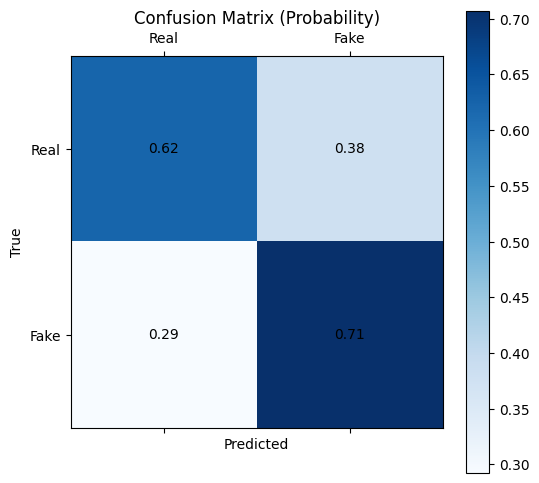

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 繪製混淆矩陣函數
def plot_confusion_matrix_with_probability(y_true, y_pred, class_names):
    """
    繪製混淆矩陣，值顯示為概率，使用藍色調。
    :param y_true: 真實標籤
    :param y_pred: 預測標籤
    :param class_names: 標籤名稱列表
    """
    cm = confusion_matrix(y_true, y_pred, normalize="true")  # Normalize rows to probabilities
    fig, ax = plt.subplots(figsize=(6, 6))

    # 繪製混淆矩陣
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # 在混淆矩陣內顯示值
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")

    # 設置標籤名稱
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # 軸標題
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Probability)")
    plt.show()

# 獲取所有測試集的預測結果和真實標籤
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 繪製混淆矩陣
plot_confusion_matrix_with_probability(all_labels, all_preds, class_names=["Real", "Fake"])
